In [37]:
import jax
import jax.numpy as np
import jraph
import flax.linen as nn
import numpy as onp
import matplotlib.pyplot as plt

from functools import partial

In [38]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [39]:
import sys
sys.path.append("../")

from models.gnn import GraphConvNet
from models.graph_utils import nearest_neighbors
from models.graph_utils import add_graphs_tuples
from datasets import load_data

In [40]:
k = 10

In [87]:
x = np.load("/Users/smsharma/Downloads/halos_small.npy")[:, :500, :]
x = (x - x.mean((0, 1))) / x.std((0, 1))

In [88]:
sources, targets = jax.vmap(nearest_neighbors, in_axes=(0, None))(x[:2], k)

## EGNN

In [89]:
from models.egnn import EGNN

In [90]:
class GraphWrapper(nn.Module):
    @nn.compact
    def __call__(self, x):
        model = jax.vmap(EGNN(
                        message_passing_steps=2, d_hidden=64, n_layers=3, skip_connections=False,
                ))
        return model(x)
    
model = GraphWrapper()
rng = jax.random.PRNGKey(42)

## Test equivariance

In [91]:
from models.graph_utils import rotate_representation

In [168]:
graph = jraph.GraphsTuple(
          n_node=np.array(2 * [[n_nodes]]), 
          n_edge=np.array(2 * [[k]]),
          nodes=x[0:2, :, :], 
          edges=None,
          globals=np.ones((2, 7)),
          senders=sources,
          receivers=targets)

graph_out, _ = model.init_with_output(rng, graph)

x_out = graph_out.nodes

angle_deg = 45.
axis = np.array([0, 1 / np.sqrt(2), 1 / np.sqrt(2)])

x_out_rot = jax.vmap(rotate_representation, in_axes=(0,None,None))(x_out, angle_deg, axis)

def get_rotated(x_rot):

    graph = jraph.GraphsTuple(
              n_node=np.array(2 * [[n_nodes]]), 
              n_edge=np.array(2 * [[k]]),
              nodes=x_rot,
              edges=None,
              globals=np.ones((2, 7)),
              senders=sources,
              receivers=targets)

    graph_out, params = model.init_with_output(rng, graph)
    x_out = graph_out.nodes
    
    return x_out

x_out = get_rotated(jax.vmap(rotate_representation, in_axes=(0,None,None))(x[0:2, :, :], angle_deg, axis))

In [169]:
# Equivariance ratio
eq_ratio = x_out / x_out_rot
print(eq_ratio.max(), eq_ratio.min(), eq_ratio)

1.0022743 0.9927798 [[[1.0000001  0.9999999  1.0000001  ... 0.99999976 0.99999994 1.0000001 ]
  [0.9999995  0.99999994 1.0000048  ... 1.0000001  0.99999976 1.0000002 ]
  [1.         0.9999999  0.9999998  ... 1.0000001  1.0000001  0.99999994]
  ...
  [1.         1.0000001  1.         ... 0.99999976 0.9999993  0.99999726]
  [1.0000001  0.9999999  1.0000001  ... 1.         1.         1.0000001 ]
  [0.9999993  1.0000001  0.9999999  ... 1.0000006  1.0000007  1.0000007 ]]

 [[1.         1.         0.9999999  ... 0.9999973  0.99999934 0.9999991 ]
  [0.99999994 1.0000002  0.99999994 ... 1.0000005  1.0000002  1.        ]
  [1.0000001  1.         0.99999994 ... 0.99999934 1.0000008  1.0000008 ]
  ...
  [0.99999934 0.9999949  0.99999994 ... 0.99999994 0.99999994 1.0000023 ]
  [1.         1.         1.         ... 0.99999946 0.9999995  0.9999994 ]
  [0.9999999  1.         1.0000001  ... 1.0000011  1.0000002  0.9999987 ]]]


In [96]:
sum(x.size for x in jax.tree_util.tree_leaves(params))

60422

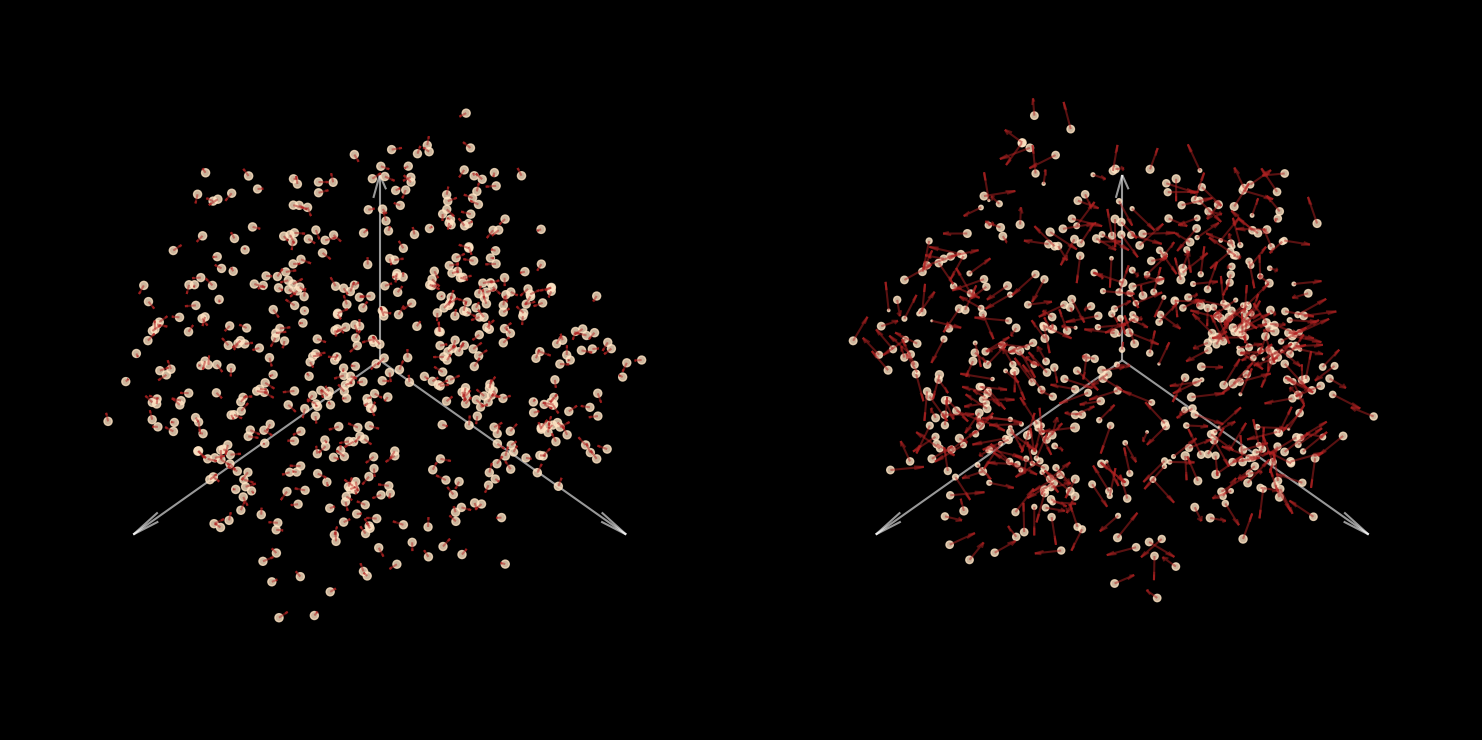

In [160]:
import matplotlib.pyplot as plt

plt.style.use('dark_background')

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 7.5), subplot_kw={'projection': '3d'})

xx, yy, zz = np.zeros((3,3))
uu, vv, ww = 3. * np.array([[1,0,0],[0,1,0],[0,0,1]])

angle_deg = 22
x_rot = jax.vmap(rotate_representation, in_axes=(0,None,None))(x, angle_deg, axis)

x_plot = x_rot[0, :, :3]
velocities_plot = x_rot[0, :, 3:6]
masses_plot = 100 * np.exp(x_rot[0, :, -1])


axs[0].scatter(x_plot[:, 0], x_plot[:, 1], x_plot[:, 2], alpha=0.8, s=masses_plot, color="bisque")
axs[0].quiver(x_plot[:, 0], x_plot[:, 1], x_plot[:, 2],
              velocities_plot[:, 0], velocities_plot[:, 1], velocities_plot[:, 2],
              length=0.1, normalize=True, color="firebrick", alpha=0.5)

axs[0].set_xlabel("x")
axs[0].set_ylabel("y")
axs[0].set_zlabel("z")
axs[0].set_axis_off()
axs[0].set_xlim(-2, 2)
axs[0].set_ylim(-2, 2)
axs[0].set_zlim(-2, 2)

axs[0].view_init(45, 45, 0)
axs[0].quiver(xx,yy,zz,uu,vv,ww, arrow_length_ratio=0.1, color='white', alpha=0.6)

x_plot = x_out[0, :, :3]
velocities_plot = x_out[0, :, 3:6]
masses_plot = 100 * np.exp(x_out[0, :, -1])

axs[1].scatter(x_plot[:, 0], x_plot[:, 1], x_plot[:, 2], alpha=0.8, s=masses_plot, color="bisque")
axs[1].quiver(x_plot[:, 0], x_plot[:, 1], x_plot[:, 2],
              velocities_plot[:, 0], velocities_plot[:, 1], velocities_plot[:, 2],
              length=0.3, normalize=True, color="firebrick", alpha=0.5)

axs[1].set_xlabel("x")
axs[1].set_ylabel("y")
axs[1].set_zlabel("z")
axs[1].set_axis_off()
axs[1].set_xlim(-2, 2)
axs[1].set_ylim(-2, 2)
axs[1].set_zlim(-2, 2)

axs[1].view_init(45, 45, 0)
axs[1].quiver(xx,yy,zz,uu,vv,ww, arrow_length_ratio=0.1, color='white', alpha=0.6)

plt.tight_layout()
plt.show()

In [252]:
import numpy as np

def random_smooth_trajectories(num_frames):
    t = np.linspace(0, 1, num_frames)
    
    # Generate coefficients for smooth rotation angles (in degrees) and axes
    angle_coefficients = np.random.uniform(-45., 45., size=(4, 1))
    axis_coefficients = np.random.uniform(-0.8, 0.8, size=(4, 3))
    
    # Generate smooth rotation angles (in degrees) for each frame
    rotation_angles = angle_coefficients[0] * np.sin(np.pi * angle_coefficients[1] * t[:, np.newaxis]) \
                    + angle_coefficients[2] * np.cos(np.pi * angle_coefficients[3] * t[:, np.newaxis])

    # Generate smooth rotation axes for each frame
    rotation_axes = axis_coefficients[0] * np.sin(np.pi * axis_coefficients[1] * t[:, np.newaxis]) \
                  + axis_coefficients[2] * np.cos(np.pi * axis_coefficients[3] * t[:, np.newaxis])

    # Normalize the rotation axes
    rotation_axes /= np.linalg.norm(rotation_axes, axis=1)[:, np.newaxis]

    # Generate coefficients for smooth translations
    translation_coefficients = np.random.uniform(-0.5, 0.5, size=(4, 3))

    # Generate smooth translations for each frame
    translations = translation_coefficients[0] * np.sin(np.pi * translation_coefficients[1] * t[:, np.newaxis]) \
                 + translation_coefficients[2] * np.cos(np.pi * translation_coefficients[3] * t[:, np.newaxis])

    return rotation_angles, rotation_axes, translations

num_frames = 200  # Increase the number of frames to create a smoother animation
rotation_angles, rotation_axes, translations = random_smooth_trajectories(num_frames)


In [261]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Helvetica"
})

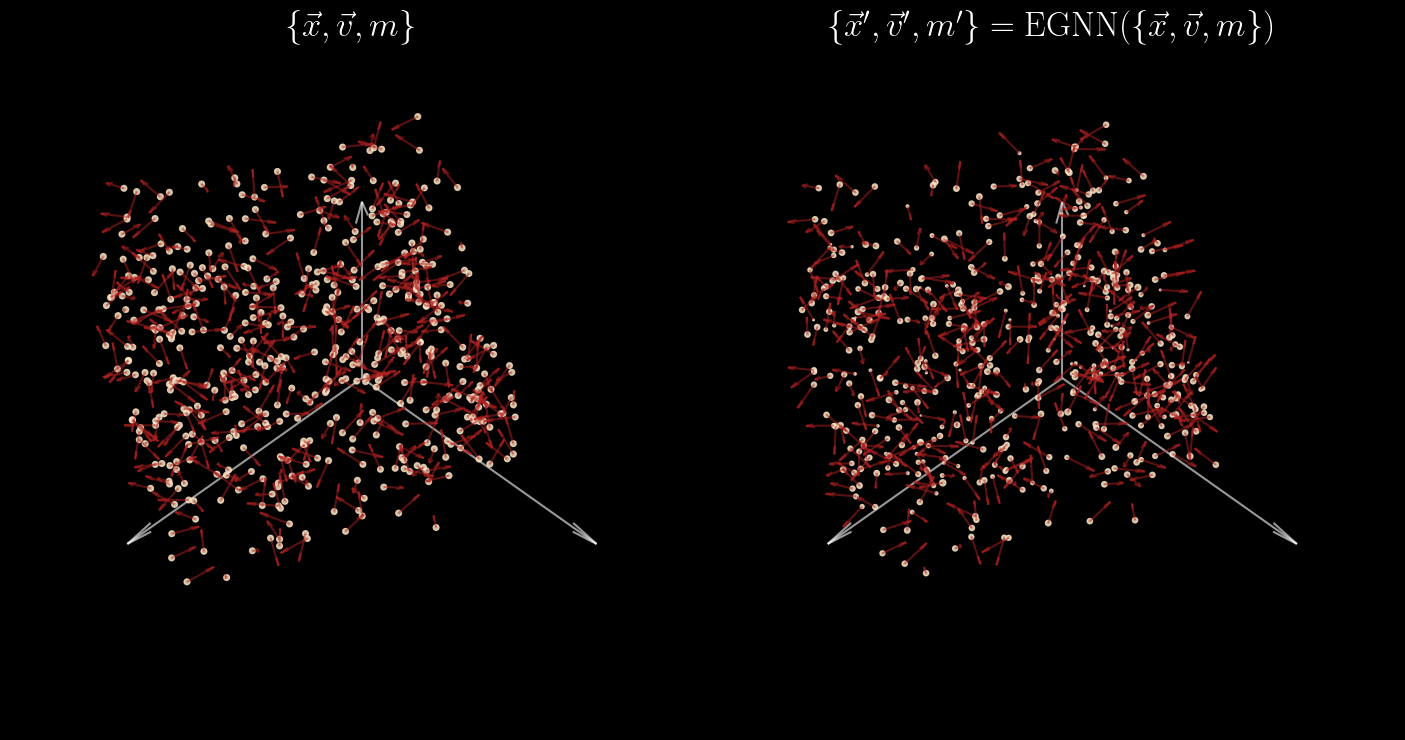

In [263]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation

plt.style.use('dark_background')

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 7.5), subplot_kw={'projection': '3d'})

xx, yy, zz = np.zeros((3,3))
uu, vv, ww = 3. * np.array([[1,0,0],[0,1,0],[0,0,1]])

def update(frame):
    
    axs[0].clear()
    axs[1].clear()
    
    angle_deg = rotation_angles[frame][0]
    axis = rotation_axes[frame]
    x_tran = translations[frame]
            
    x_rot = np.array(jax.vmap(rotate_representation, in_axes=(0,None,None))(x, angle_deg, axis))
    x_rot[:, :, :3] += x_tran[None, None, :]

    x_plot = x_rot[0, :, :3]
    velocities_plot = x_rot[0, :, 3:6]
    masses_plot = 50 * np.exp(x_rot[0, :, -1])


    axs[0].scatter(x_plot[:, 0], x_plot[:, 1], x_plot[:, 2], alpha=0.8, s=masses_plot, color="bisque")
    axs[0].quiver(x_plot[:, 0], x_plot[:, 1], x_plot[:, 2],
                  velocities_plot[:, 0], velocities_plot[:, 1], velocities_plot[:, 2],
                  length=0.3, normalize=True, color="firebrick", alpha=0.5)

    axs[0].set_axis_off()
    axs[0].set_xlim(-2, 2)
    axs[0].set_ylim(-2, 2)
    axs[0].set_zlim(-2, 2)

    axs[0].view_init(45, 45, 0)
    axs[0].quiver(xx,yy,zz,uu,vv,ww, arrow_length_ratio=0.1, color='white', alpha=0.6)
    axs[0].set_title(r"$\{\vec x, \vec v, m\}$", fontsize=25)

    x_out = get_rotated(x_rot[:2])

    x_plot = x_out[0, :, :3]
    velocities_plot = x_out[0, :, 3:6]
    masses_plot = 50 * np.exp(x_out[0, :, -1])

    axs[1].scatter(x_plot[:, 0], x_plot[:, 1], x_plot[:, 2], alpha=0.8, s=masses_plot, color="bisque")
    axs[1].quiver(x_plot[:, 0], x_plot[:, 1], x_plot[:, 2],
                  velocities_plot[:, 0], velocities_plot[:, 1], velocities_plot[:, 2],
                  length=0.3, normalize=True, color="firebrick", alpha=0.5)

    axs[1].set_axis_off()
    axs[1].set_xlim(-2, 2)
    axs[1].set_ylim(-2, 2)
    axs[1].set_zlim(-2, 2)

    axs[1].view_init(45, 45, 0)
    axs[1].quiver(xx,yy,zz,uu,vv,ww, arrow_length_ratio=0.1, color='white', alpha=0.6)

    axs[1].set_title(r"$\{\vec x', \vec v', m'\} = \mathrm{EGNN}(\{\vec x, \vec v, m\})$", fontsize=25)

    plt.tight_layout()

ani = FuncAnimation(fig, update, frames=np.arange(num_frames))
plt.tight_layout()

# Save the animation as a gif
# ani.save('3d_animation.gif', writer='imagemagick', fps=5)

import matplotlib.animation as animation
FFwriter = animation.FFMpegWriter(fps=20)
ani.save('3d_animation.mp4', writer=FFwriter)

plt.show()